In [4]:
import os
import json
import matplotlib.pyplot as plt

In [5]:
class End_of_File(Exception):
    pass
class log_handler():
    def __init__(self, model, exp_id):
        assert model in ['M-K80', 'M-V100']
        sub_dir = 'Results'
        dumped = 'Dumped'
        name = 'train.log'
        self.path = os.path.join(os.getcwd(),sub_dir, model, dumped, exp_id, name)
        self.file = open(self.path, 'r')
        self.lines = []
    def get_line(self):
        l = ''
        while True:
            temp = self.file.readline()
            temp = temp.strip().split('-')
            temp = '-'.join(temp)
            l = l + temp
            if not self.has_next():
                self.lines.append(l)
                return l

    def has_next(self):
        p = self.file.tell()
        temp = self.file.readline()
        self.file.seek(p)
        temp = temp.replace(' ', '')
        temp = temp.strip().split('-')
        key = temp[0]
        if key in ['INFO', 'WARNING']:
            return False
        else:
            return True
            
    def close(self):
        self.file.close()
        print('File closed')

In [6]:
def get_train_loss(model, exp_id, num_epoch = 10):
    df = log_handler(model, exp_id)
    train_loss = []
    for i in range(num_epoch):
        while True:
            num_iter = 0
            loss = 0
            st = df.get_line()
            st = st.strip().split(' - ')
            data = st[3]
            idx1 = data.find('Starting epoch')
            if idx1 == -1:
                continue
            else:
                idx2 = data.find('...')
                epoch = int(data[idx1:idx2].strip().split(' ')[2])
                while True:
                    st = df.get_line()
                    if check_end_epoch(st):
                        loss = 0 if (num_iter == 0) else loss/num_iter
                        train_loss.append((epoch, loss))
                        loss = 0
                        num_iter = 0
                        break
                    else:
                        loss = loss + get_loss(st)
                        num_iter += 1
                break
    return train_loss

def get_valid_test_loss(model, exp_id, num_epoch = 10):
    df = log_handler(model, exp_id)
    losses = []
    for i in range(num_epoch):
        while True:
            st = df.get_line()
            idx1 = st.find(' __log__:')
            if idx1 == -1:
                continue
            else:
                idx1 = st.find('{')
                s = st[idx1:]
                dic = json.loads(s)
                losses.append(dic)
                break
    return losses
                    
def get_loss(st):
    idx1 = st.find('PRIM-BWD:')
    idx2 = st.find(' - prim_bwd-AVG-STOP-PROB')
    loss = float(st[idx1:idx2].strip().split(' ')[2])
    return loss
def check_end_epoch(st):
    st = st.strip().split(' - ')
    data = st[3]
    idx1 = data.find('End of epoch')
    if idx1 == -1:
        return False
    else:
        return True
def plot(model, exp_id, num_epoch = 10):
    losses = get_valid_test_loss(model, exp_id, num_epoch)
    train_loss = get_train_loss(model, exp_id, num_epoch)
    assert len(train_loss) == len(losses)
    epochs = []
    train_ce = []
    valid_ce = []
    valid_ac = []
    test_ce = []
    test_ac = []
    for i in range(len(train_loss)):
        epochs.append(train_loss[i][0])
        train_ce.append(train_loss[i][1])
        valid_ce.append(losses[i]['valid_prim_bwd_xe_loss'])
        valid_ac.append(losses[i]['valid_prim_bwd_acc'])
        test_ce.append(losses[i]['test_prim_bwd_xe_loss'])
        test_ac.append(losses[i]['test_prim_bwd_acc'])
    plt.plot(epochs, train_ce, 'g', label='Train Cross Entropy loss')
    plt.plot(epochs, valid_ce, 'k', label='Validation Cross Entropy loss')
    plt.plot(epochs, test_ce, 'y', label='Test Cross Entropy loss')
    plt.plot(epochs, valid_ac, 'b', label='Validation accuracy')
    plt.plot(epochs, test_ac, 'r', label='Test accuracy')
    plt.title(f'{model}-{exp_id}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.show()

In [27]:
model = 'M-V100'
exp_id = '7'
num_epoch = 31

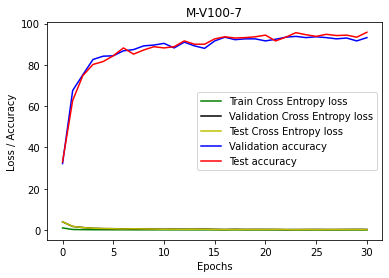

In [28]:
plot(model, exp_id, num_epoch)
